In [1]:
import sys 
sys.path.append('..') 

import glob
import numpy as np 
import json 
import h5py
 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.cm as cm

from scipy.spatial.distance import cosine

from hyperion.model import ModelOutput

import caesar 

import sphviewer as sph
from sphviewer.tools import cmaps

from simba import simba 
sb = simba()

In [2]:
def recalculate_ang_mom_vector(_g,ptype=4):
    """
    Recalculate angular momentum vector
    """
    fname = '/orange/narayanan/desika.narayanan/gizmo_runs/simba/m100n1024/snap_m100n1024_078.hdf5'
        
    if ptype==0: plist = np.sort(_g.glist)
    elif ptype==4: plist = np.sort(_g.slist)
    
    with h5py.File(fname, 'r') as f:
        _h = f['Header'].attrs['HubbleParam']
        _a = f['Header'].attrs['Time']

        _masses = f['PartType%s/Masses'%ptype][plist] 
        _vels = f['PartType%s/Velocities'%ptype][plist] * _a * (1/_h) 
        _coods = f['PartType%s/Coordinates'%ptype][plist] * (1/_h)
         
    _vels  -= _g.vel.value 
    _coods -= _g.pos.value 

    R = np.sqrt(np.sum(_coods**2,axis=1))

    mask = R < 100;
     
    L = np.sum(np.cross(_coods[mask], (_vels[mask] * _masses[mask,None])),axis=0)
    return L 

def get_image_array(P,coods,extent,p=0,t=0,roll=0):
 
    C = sph.Camera(x=coods[0], y=coods[1], z=coods[2], 
                   r='infinity', zoom=1,
                   t=t, p=p, roll=roll,
                   extent=[-extent,extent,-extent,extent],
                   xsize=512, ysize=512)
 
    S = sph.Scene(P, Camera=C)
    R = sph.Render(S)
    img = R.get_image()
    
    return img


def plot_dist(fig, ax,P,coods,cmap,
              vmin=1e-4,vmax=None,extent=300,
              p=0,t=0,roll=0):
 
    img = get_image_array(P,coods,extent,p,t,roll)

    if vmax is None:    
        vmax = img.max()

    if vmin > vmax:
        print("vmin larger than vmax! Setting lower")
        vmin = img.max() / 10
    print("vmin,vmax:",vmin,vmax)
    
    cNorm  = colors.LogNorm(vmin=vmin,vmax=vmax)
    sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)

    ax.imshow(img, extent=[-extent,extent,-extent,extent],
              cmap=cmap, norm=cNorm)

    return sm,img


# def transform_sph_coods(theta,phi):
#     """
#     transform rotation (alpha -> theta, beta -> phi)
#     """
#     theta += np.pi
#     phi += np.pi

#     x = np.round(np.sin(theta),2) * np.round(np.cos(phi),2) 
#     y = np.round(np.sin(theta),2) * np.round(np.sin(phi),2) 
#     z = np.round(np.cos(theta),2) 

#     alpha = np.arctan( (np.round(np.sin(phi),2) * np.round(np.sin(theta),2)) / np.round(np.cos(theta),2) ) 
#     alpha[(z<0) & (y>=0)] += np.pi 
#     alpha[(z<0) & (y<0)] -= np.pi 
#     alpha[(z==0) & (y>0)] = np.pi/2 
#     alpha[(z==0) & (y<0)] = -np.pi/2 

#     beta = np.arctan( (np.round(np.sin(theta),2) * np.round(np.cos(phi),2)) / np.round(np.cos(theta),2) ) 
#     # beta[(z<0) & (x>=0)] += np.pi  
#     # beta[(z<0) & (x<0)] -= np.pi  
#     # beta[(z==0) & (x>0)] = np.pi/2  
#     # beta[(z==0) & (x<0)] = -np.pi/2  

#     alpha *= 180./np.pi
#     beta  *= 180./np.pi
#     return alpha,beta

def transform_coods(theta,phi,tol=20,test=False):
    alpha = np.arcsin(-1 * np.round(np.sin(theta),tol) * np.round(np.sin( phi ),tol))
    beta = np.round(np.arcsin((np.round(np.cos(phi),tol) * np.round(np.sin(theta),tol)) / np.round(np.cos(alpha),tol)),tol)

    beta[np.isnan(beta)] = 0.
    mask = (theta > np.pi/2)
    beta[mask] = np.arccos(     np.round(np.cos(theta[mask]),tol) / np.round(np.cos(alpha[mask]),tol))
    mask = (phi > np.pi/2) & (phi < 3*np.pi/2) & (theta > np.pi/2)
    beta[mask] = -beta[mask]

    if test:
        x = np.round(np.sin(theta),tol) * np.round(np.cos(phi),tol)
        y = np.round(np.sin(theta),tol) * np.round(np.sin(phi),tol)
        z = np.round(np.cos(theta),tol)
        out = np.array([x,y,z]).T

        c  = np.round(np.cos(alpha),tol); s  = np.round(np.sin(alpha),tol)
        Rx = np.array([[1.0,0.0,0.0],[0.0,  c, -s],[0.0,  s,  c]])

        c  = np.round(np.cos(beta),tol); s  = np.round(np.sin(beta),tol)
        Ry = np.array([[  c,0.0, s],[0.0,1.0,0.0],[ -s,0.0,  c]])
        V = np.array([0,0,1])#.T

        out2 = np.round(np.vstack(np.dot(np.dot(Ry,Rx),V)).T,tol)
        print(np.round(out,2),"\n\n",np.round(out2,2),"\n")

        match = np.round(out,5) == np.round(out2,5)
        print(np.sum(match),np.product(match.shape))

    return np.round(alpha,tol),np.round(beta,tol)



In [18]:
snap = '078'
z = 2.025

_dat = json.load(open('m100/galaxy_selection.json','r'))

cs = caesar.load('%sm100n1024_%s.hdf5'%(sb.cs_directory,snap))
    
## spherical coordinates of viewing angle in box coordinates (not pd)
# phi   = np.array([0,90,180,270,0,0]) * (np.pi/180.)
# theta = np.array([90,90,90,90,0,180]) * (np.pi/180.)


filt_wl, filt_trans = sb.scuba850_filter()


norm = mpl.colors.Normalize(vmin=0, vmax=1)
m = cm.ScalarMappable(norm=norm, cmap=cm.copper)

gidx = 3
# _N = 10
# np.random.seed(0)
# theta = np.arccos(1 - 2 * np.random.rand(_N)) #* (180 / np.pi)
# phi   = 2 * np.pi * np.random.rand(_N) #* (180 / np.pi)
theta = np.array([90,90, 90, 90,0,180]) * np.pi/180.
phi = np.array([0, 90,180,270,0,  0]) * np.pi/180.

print(gidx)
_g = cs.galaxies[gidx]     

coods = np.zeros((len(theta),3))
coods[:,0] = np.sin(theta) * np.cos(phi)
coods[:,1] = np.sin(theta) * np.sin(phi)
coods[:,2] = np.cos(theta)
coods = np.round(coods,2)

_L = recalculate_ang_mom_vector(_g,ptype=0)
# cos_dist = [round(1 - cosine(_c,_g.rotation['baryon_L']),3) for _c in coods] 
cos_dist = [round(1 - cosine(_c,_L),3) for _c in coods] 
print(gidx,np.log10(np.linalg.norm(_L)))
print(cos_dist)

yt : [INFO     ] 2020-12-01 07:57:20,003 Opening /orange/narayanan/desika.narayanan/gizmo_runs/simba/m100n1024/Groups/m100n1024_078.hdf5
yt : [INFO     ] 2020-12-01 07:57:20,102 Found 545417 halos
yt : [INFO     ] 2020-12-01 07:57:20,112 Found 30743 galaxies


3
3 5.0809946
[-0.809, -0.255, 0.809, 0.255, -0.529, 0.529]


yt : [INFO     ] 2020-12-01 11:11:39,042 Opening /orange/narayanan/desika.narayanan/gizmo_runs/simba/m100n1024/Groups/m100n1024_078.hdf5
yt : [INFO     ] 2020-12-01 11:11:39,582 Found 545417 halos
yt : [INFO     ] 2020-12-01 11:11:40,361 Found 30743 galaxies


/blue/narayanan/c.lovell/simba/m100n1024/out/snap_078/subset_00000.h5
0.33062 0.6774 0.48807203169481855
Getting gas particles...
Getting star particles...
Getting dark matter particles...


/home/c.lovell/.conda/envs/pday/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/c.lovell/.conda/envs/pday/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/c.lovell/.conda/envs/pday/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/c.lovell/.conda/envs/pday/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/c.lovell/.conda/envs/pday/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value

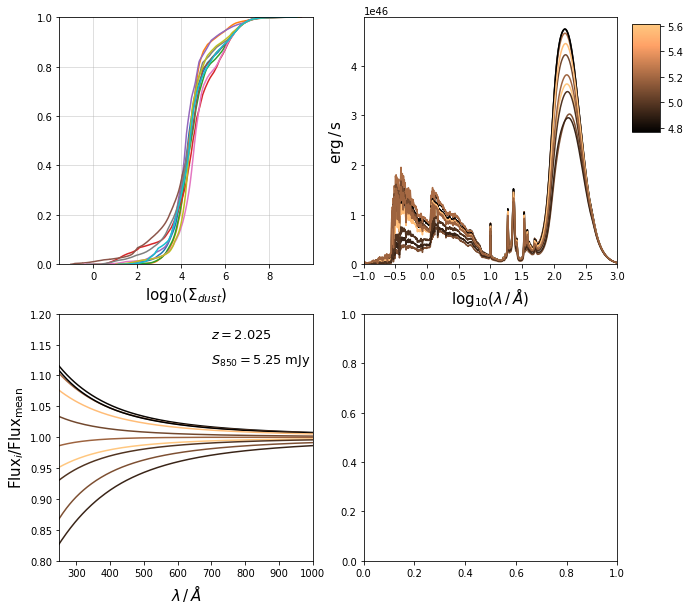

In [89]:

np.random.seed(0)
theta = np.arccos(1 - 2 * np.random.rand(10)) * (180 / np.pi) #[0,90,180,270,90,270] 
phi   = 2 * np.pi * np.random.rand(10) * (180 / np.pi)        #[0,0 ,0  ,0  ,90,90 ] 

# theta = np.array([90,90, 90, 90,0,180]) * np.pi/180.
# phi = np.array([0, 90,180,270,0,  0]) * np.pi/180.
alpha, beta = transform_sph_coods(theta,phi)

_dat = json.load(open('m100/galaxy_selection.json','r'))
for gidx in ['3']:#,'3','8','51','54','94','100','134','139']:

    cs = caesar.load('%sm100n1024_%s.hdf5'%(sb.cs_directory,snap))
    #_mstar = np.log10(cs.galaxies[int(gidx)].masses['stellar'])
    #print("Mstar:",_mstar)

    hcood =  np.array(_dat[snap][gidx]['pos'])
    hidx =  _dat[snap][gidx]['hidx']

    fdir = '/blue/narayanan/c.lovell/simba/m100n1024/out/snap_078/subset_%05d.h5'%hidx
    print(fdir)
    # fdir ='/cosma7/data/dp104/dc-dave2/sim/m100n1024/s50j7k/snap_m100n1024_%s.hdf5'%snap

    with h5py.File(fdir,'r') as f:
        _a = np.float32(1. / (1+f['Header'].attrs['Redshift']))
        _h = np.float32(sb.cosmo.h)
        _temp = (1. / _h) * _a
        print(_a,_h,_temp)

        print("Getting gas particles...")
        #halog_pos = (np.array(f['PartType0/Coordinates'][()]) * _temp).astype(np.float32)
        halog_pos = f['PartType0/Coordinates'][()] * _temp
        halog_mass = f['PartType0/Masses'][()]
        halog_dust = f['PartType0/Dust_Masses'][()]
        halog_sfr = f['PartType0/StarFormationRate'][()]

        print("Getting star particles...")
        halos_pos = (np.array(f['PartType4/Coordinates'][()]) * _temp).astype(np.float32)
        halos_pmass = f['PartType4/Masses'][()]

        print("Getting dark matter particles...")
        halod_pos = (f['PartType1/Coordinates'][()] * _temp).astype(np.float32)

    hcood *= _temp

    
    fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
    
    cum_density = np.zeros(len(alpha))
    _temp_counter = 0
    for _i,(_p,_t) in enumerate(zip(beta, alpha)):

        extent = 30
        mask = np.random.rand(len(halog_pos)) < 1
        Pd = sph.Particles(halog_pos[mask], halog_dust[mask] * 1e10) 
        # Pg = sph.Particles(halog_pos[mask], halog_mass[mask] * 1e10) 
        Psfr = sph.Particles(halog_pos[mask], halog_sfr[mask]) 

        # mask = np.random.rand(len(halos_pos)) < 1
        # Ps = sph.Particles(halos_pos[mask], halos_pmass[mask] * 1e10) 

        img2 = get_image_array(Psfr, hcood, extent=extent, p=_p, t=_t)
        img3 = get_image_array(Pd, hcood, extent=extent, p=_p, t=_t)
        _y = np.log10(np.hstack(img3[100:-100,100:-100]))
#         _y = np.log10(np.hstack(img2/img3))
#         _y = np.hstack(np.log10(img2[100:-100,100:-100]/img3[100:-100,100:-100]))
#         _y /= _y.max()
        ax1.step(np.sort(_y), np.arange(len(_y))/len(_y))
        cum_density[_i] = np.percentile(_y,80)
    
    
    norm = mpl.colors.Normalize(vmin=cum_density.min(), vmax=cum_density.max())
    m = cm.ScalarMappable(norm=norm, cmap=cm.copper)
    
    rt_directory = '/blue/narayanan/c.lovell/simba/m100n1024/run_sed'
    snap_fname = f'{rt_directory}/snap_{snap}_hires2/gal_{gidx}/snap{snap}.galaxy*.rtout.sed'
    fname = glob.glob(snap_fname)[0]

    wav,spec = sb.get_spectrum(fname,gal_id=None)
    flux_850 = sb.calc_mags(wav.copy(), spec.copy(), z,
                            filt_wl=filt_wl, filt_trans=filt_trans).value
        
    [ax2.plot(np.log10(wav.value * (1+z)), s, #/ wav.value * (1+z), 
              alpha=1, c=m.to_rgba(cum_density[i])) for i,s in enumerate(spec)]

    mean_spec = np.mean(spec.value,axis=0)
    [ax3.plot(wav.value * (1+z), s/mean_spec, 
              alpha=1, 
            c=m.to_rgba(cum_density[i])) for i,s in enumerate(spec)]

    for ax in [ax2]:
        ax.set_ylim(0,)
        ax.set_xlabel('$\mathrm{log_{10}}(\lambda \,/\, \AA)$', size=15)
        ax.set_ylabel('$\mathrm{erg \,/\, s}$', size=15)
    

    mean_flux = np.round(np.mean(flux_850),2)
    ax3.text(0.6,0.9,f'$z = {z}$',size=13,transform=ax3.transAxes)
    ax3.text(0.6,0.8,'$S_{850} = %s \; \mathrm{mJy}$'%mean_flux,size=13,transform=ax3.transAxes)
    ax3.set_xlabel('$\lambda \,/\, \AA$',size=15)
    ax3.set_ylabel('$\mathrm{Flux}_i / \mathrm{Flux_{mean}}$',size=15)
    ax3.set_ylim(0.8,1.2); 
    ax3.set_xlim(250,1000)
    ax2.set_xlim(-1,3)
    ax1.set_xlabel('$\mathrm{log_{10}} (\Sigma_{dust})$',size=15)
    ax1.grid(alpha=0.5); ax1.set_ylim(0,1)

    cax = fig.add_axes([0.92, 0.72, 0.04, 0.15])
    cbar = fig.colorbar(m, aspect=10, orientation='vertical', cax=cax)
    plt.show()
#     plt.savefig(f'plots/dust_surface_density_g{gidx}.png',dpi=300,bbox_inches='tight')

<ipython-input-4-e306e5b66db4>:50: RuntimeWarning: divide by zero encountered in true_divide
  alpha = np.arctan( (np.round(np.sin(phi),2) * np.round(np.sin(theta),2)) / np.round(np.cos(theta),2) )
<ipython-input-4-e306e5b66db4>:50: RuntimeWarning: invalid value encountered in true_divide
  alpha = np.arctan( (np.round(np.sin(phi),2) * np.round(np.sin(theta),2)) / np.round(np.cos(theta),2) )
<ipython-input-4-e306e5b66db4>:56: RuntimeWarning: divide by zero encountered in true_divide
  beta = np.arctan( (np.round(np.sin(theta),2) * np.round(np.cos(phi),2)) / np.round(np.cos(theta),2) )
<ipython-input-4-e306e5b66db4>:56: RuntimeWarning: invalid value encountered in true_divide
  beta = np.arctan( (np.round(np.sin(theta),2) * np.round(np.cos(phi),2)) / np.round(np.cos(theta),2) )
yt : [INFO     ] 2020-12-01 11:12:20,520 Opening /orange/narayanan/desika.narayanan/gizmo_runs/simba/m100n1024/Groups/m100n1024_078.hdf5
yt : [INFO     ] 2020-12-01 11:12:20,611 Found 545417 halos
yt : [INFO     

/blue/narayanan/c.lovell/simba/m100n1024/out/snap_078/subset_00000.h5
0.33062 0.6774 0.48807203169481855
Getting gas particles...
Getting star particles...
Getting dark matter particles...


<ipython-input-91-57db6320d3ab>:63: RuntimeWarning: divide by zero encountered in log10
  _y = np.hstack(np.log10(img2[100:-100,100:-100]/img3[100:-100,100:-100]))


vmin,vmax: 0.1 1478518800.0
-6.6070643901824955


<ipython-input-91-57db6320d3ab>:63: RuntimeWarning: divide by zero encountered in log10
  _y = np.hstack(np.log10(img2[100:-100,100:-100]/img3[100:-100,100:-100]))


vmin,vmax: 0.1 1525324400.0
-6.844994425773622


<ipython-input-91-57db6320d3ab>:63: RuntimeWarning: divide by zero encountered in log10
  _y = np.hstack(np.log10(img2[100:-100,100:-100]/img3[100:-100,100:-100]))


vmin,vmax: 0.1 2049701500.0
-6.723983836174011


<ipython-input-91-57db6320d3ab>:63: RuntimeWarning: divide by zero encountered in log10
  _y = np.hstack(np.log10(img2[100:-100,100:-100]/img3[100:-100,100:-100]))
/home/c.lovell/.conda/envs/pday/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/c.lovell/.conda/envs/pday/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/c.lovell/.conda/envs/pday/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/c.lovell/.conda/envs/pday/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_u

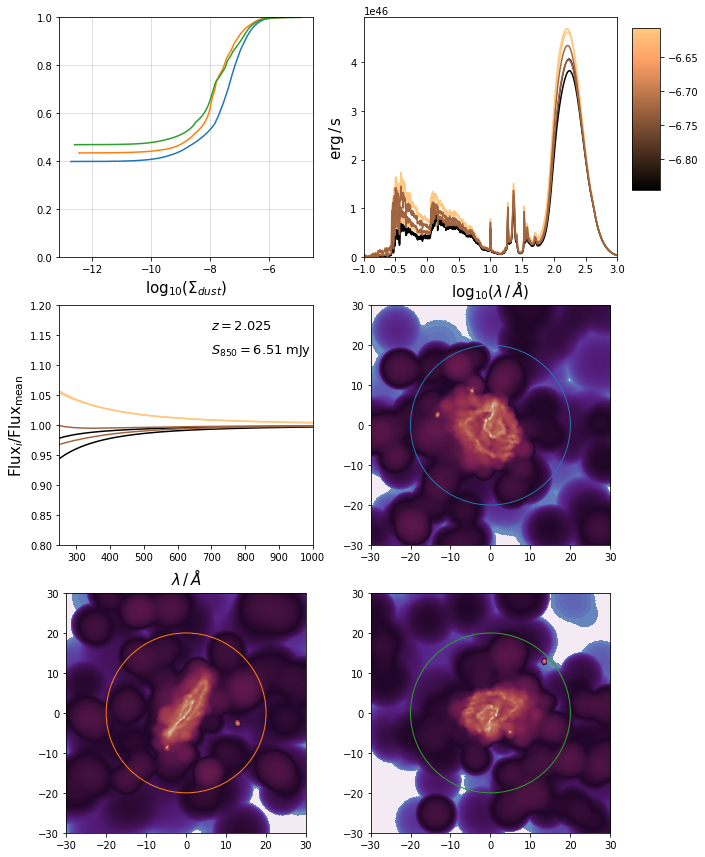

In [91]:
theta = np.array([90,90, 90, 90,0,180]) * np.pi/180.
phi = np.array([0, 90,180,270,0,  0]) * np.pi/180.
alpha, beta = transform_sph_coods(theta,phi)

_dat = json.load(open('m100/galaxy_selection.json','r'))
for gidx in ['3']:#,'3','8','51','54','94','100','134','139']:

    cs = caesar.load('%sm100n1024_%s.hdf5'%(sb.cs_directory,snap))
    #_mstar = np.log10(cs.galaxies[int(gidx)].masses['stellar'])
    #print("Mstar:",_mstar)

    hcood =  np.array(_dat[snap][gidx]['pos'])
    hidx =  _dat[snap][gidx]['hidx']

    fdir = '/blue/narayanan/c.lovell/simba/m100n1024/out/snap_078/subset_%05d.h5'%hidx
    print(fdir)
    # fdir ='/cosma7/data/dp104/dc-dave2/sim/m100n1024/s50j7k/snap_m100n1024_%s.hdf5'%snap

    with h5py.File(fdir,'r') as f:
        _a = np.float32(1. / (1+f['Header'].attrs['Redshift']))
        _h = np.float32(sb.cosmo.h)
        _temp = (1. / _h) * _a
        print(_a,_h,_temp)

        print("Getting gas particles...")
        #halog_pos = (np.array(f['PartType0/Coordinates'][()]) * _temp).astype(np.float32)
        halog_pos = f['PartType0/Coordinates'][()] * _temp
        halog_mass = f['PartType0/Masses'][()]
        halog_dust = f['PartType0/Dust_Masses'][()]
        halog_sfr = f['PartType0/StarFormationRate'][()]

        print("Getting star particles...")
        halos_pos = (np.array(f['PartType4/Coordinates'][()]) * _temp).astype(np.float32)
        halos_pmass = f['PartType4/Masses'][()]

        print("Getting dark matter particles...")
        halod_pos = (f['PartType1/Coordinates'][()] * _temp).astype(np.float32)

    hcood *= _temp

    
    fig,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(10,15))
    
    cum_density = np.zeros(len(alpha))
    _temp_counter = 0
    for _i,(_ax,_orientation,_p,_t,_roll) in enumerate(zip([ax4,ax5,False,False,ax6,False],
                                                             [0,   1,   2,   3,   4,   5],
                                                             beta, alpha, [270,180,270,0,270,90])):

        extent = 30
        mask = np.random.rand(len(halog_pos)) < 1
        Pd = sph.Particles(halog_pos[mask], halog_dust[mask] * 1e10) 
        # Pg = sph.Particles(halog_pos[mask], halog_mass[mask] * 1e10) 
        Psfr = sph.Particles(halog_pos[mask], halog_sfr[mask]) 

        # mask = np.random.rand(len(halos_pos)) < 1
        # Ps = sph.Particles(halos_pos[mask], halos_pmass[mask] * 1e10) 

        img2 = get_image_array(Psfr, hcood, extent=extent, p=_p, t=_t, roll=_roll)
        img3 = get_image_array(Pd, hcood, extent=extent, p=_p, t=_t, roll=_roll)
        # _y = np.log10(np.hstack(img3[100:-100,100:-100]))
#         _y = np.log10(np.hstack(img2/img3))
        _y = np.hstack(np.log10(img2[100:-100,100:-100]/img3[100:-100,100:-100]))
#         _y /= _y.max()
        if _ax: ax1.step(np.sort(_y), np.arange(len(_y))/len(_y))
        
        cum_density[_i] = np.percentile(_y, 95)
        
        if _ax:
            sm3,img3 = plot_dist(fig, _ax, Pd, hcood, cmaps.twilight(), 
                                 vmin=1e-1, extent=extent, p=_p, t=_t, roll=_roll)
            
            circle1 = plt.Circle((0, 0), 20, color='C%s'%_temp_counter, fill=False)
            _ax.add_artist(circle1)
            _temp_counter += 1
            print(cum_density[_i])
    
    
    norm = mpl.colors.Normalize(vmin=cum_density.min(), vmax=cum_density.max())
    m = cm.ScalarMappable(norm=norm, cmap=cm.copper)
    
    rt_directory = '/blue/narayanan/c.lovell/simba/m100n1024/run'
    snap_fname = f'{rt_directory}/snap_{snap}/gal_{gidx}/snap{snap}.galaxy*.rtout.sed'
    fname = glob.glob(snap_fname)[0]

    wav,spec = sb.get_spectrum(fname,gal_id=None)
    flux_850 = sb.calc_mags(wav.copy(), spec.copy(), z,
                            filt_wl=filt_wl, filt_trans=filt_trans).value
        
    [ax2.plot(np.log10(wav.value * (1+z)), s, #/ wav.value * (1+z), 
              alpha=1, c=m.to_rgba(cum_density[i])) for i,s in enumerate(spec)]

    mean_spec = np.mean(spec.value,axis=0)
    [ax3.plot(wav.value * (1+z), s/mean_spec, 
              alpha=1, 
            c=m.to_rgba(cum_density[i])) for i,s in enumerate(spec)]

    for ax in [ax2]:
        ax.set_ylim(0,)
        ax.set_xlabel('$\mathrm{log_{10}}(\lambda \,/\, \AA)$', size=15)
        ax.set_ylabel('$\mathrm{erg \,/\, s}$', size=15)
    

    mean_flux = np.round(np.mean(flux_850),2)
    ax3.text(0.6,0.9,f'$z = {z}$',size=13,transform=ax3.transAxes)
    ax3.text(0.6,0.8,'$S_{850} = %s \; \mathrm{mJy}$'%mean_flux,size=13,transform=ax3.transAxes)
    ax3.set_xlabel('$\lambda \,/\, \AA$',size=15)
    ax3.set_ylabel('$\mathrm{Flux}_i / \mathrm{Flux_{mean}}$',size=15)
    ax3.set_ylim(0.8,1.2); 
    ax3.set_xlim(250,1000)
    ax2.set_xlim(-1,3)
    ax1.set_xlabel('$\mathrm{log_{10}} (\Sigma_{dust})$',size=15)
    ax1.grid(alpha=0.5); ax1.set_ylim(0,1)

    cax = fig.add_axes([0.92, 0.72, 0.04, 0.15])
    cbar = fig.colorbar(m, aspect=10, orientation='vertical', cax=cax)
    plt.show()
#     plt.savefig(f'plots/dust_surface_density_g{gidx}.png',dpi=300,bbox_inches='tight')

In [75]:
_y.max()

-4.9179444

In [78]:
spec.shape

(10, 2500)

In [68]:
np.log10(img2) - np.log10(img3)

<ipython-input-68-e74915d5d3b9>:1: RuntimeWarning: divide by zero encountered in log10
  np.log10(img2) - np.log10(img3)


array([[      -inf,       -inf,       -inf, ..., -6.680434 , -6.4712186,
        -6.3847895],
       [      -inf,       -inf,       -inf, ..., -6.7281866, -6.53358  ,
        -6.388006 ],
       [      -inf,       -inf,       -inf, ..., -6.7760553, -6.5785627,
        -6.3925447],
       ...,
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf]], dtype=float32)

In [65]:
img3

array([[2.3636451e+00, 2.4065688e+00, 2.4495478e+00, ..., 1.1343640e+04,
        5.6323862e+03, 3.6623164e+03],
       [2.3903844e+00, 2.4333963e+00, 2.4764621e+00, ..., 1.3158431e+04,
        6.7616123e+03, 3.8179270e+03],
       [2.4169502e+00, 2.4600487e+00, 2.5031993e+00, ..., 1.5070166e+04,
        7.6637144e+03, 3.9214390e+03],
       ...,
       [5.9245796e+03, 5.9897046e+03, 6.0490806e+03, ..., 1.9872487e+03,
        1.9560355e+03, 1.9289760e+03],
       [5.7360269e+03, 5.8003799e+03, 5.8590605e+03, ..., 1.9097340e+03,
        1.8850411e+03, 1.8603022e+03],
       [5.5440347e+03, 5.6075835e+03, 5.6655366e+03, ..., 1.8376958e+03,
        1.8159495e+03, 1.7953300e+03]], dtype=float32)

In [58]:
np.percentile(_y,90)

5.96102552208322e-08